# YouTubeDataset Examples


In [1]:
import torch
import torchvision.transforms as vTransforms
import torchvision.utils as vUtils

import torchtext
import torchtext.vocab
import torchtext.data


import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

from YouTubeDataset import YouTubeDataset
from YouTubeDataset import transforms as ytTransforms

# YouTubeDataset requires a Google Cloud API Key with YouTube Data API V3 access to
# download a dataset
#
# API Key from https://console.cloud.google.com/apis/credentials
# 

from MYAPIKEY import API_KEY

In [2]:
def show(o):
    ds = dl = None
    if isinstance(o, torch.utils.data.IterableDataset):
        ds = dl = o

    if isinstance(o, torch.utils.data.DataLoader):
        dl = o
        ds = dl.dataset
    
    if ds != None and dl != None:
        print(ds.fields)
        
        for ix, batch in enumerate(dl):
            for k, v in zip(ds.fields, batch):
                s = np.shape(v)
                if len(s) == 0:
                    print(k,v)
                else:
                    print(k,s)
        
                if k == 'VF_DATA' and isinstance(o, torch.utils.data.DataLoader):
                    plt.figure(figsize=(32,32))
                    plt.axis("off")
                    plt.title(k)
                    plt.imshow(np.transpose(vUtils.make_grid(v, padding=2).cpu(),(1,2,0)))                                
            break


## Default Dataset

Video frames as images, timestamp


In [6]:
from YouTubeDataset import YouTubeDataset

class MyTransform():
    def __init__(self):
        pass
        
    def __call__(self, x):
        print(x.dtype, x.shape)
        return x
    


transform = vTransforms.Compose([
     vTransforms.ToPILImage(),
     vTransforms.Resize((128, 128)),
     vTransforms.ToTensor()
])


ds0 = YouTubeDataset('data', 'SecretLocation', 'train', image_transform = transform,
                    download=True,
                    api_key=API_KEY,
                    user_name='thesecretlocation',
                    splits={'train':0.90, 'test':0.1})                  

show(ds0)

Files already downloaded
['VF_DATA', 'TIME']
VF_DATA torch.Size([3, 128, 128])
TIME 0.0


### With Dataloader


['VF_DATA', 'TIME']
VF_DATA torch.Size([64, 3, 128, 128])
TIME torch.Size([64])


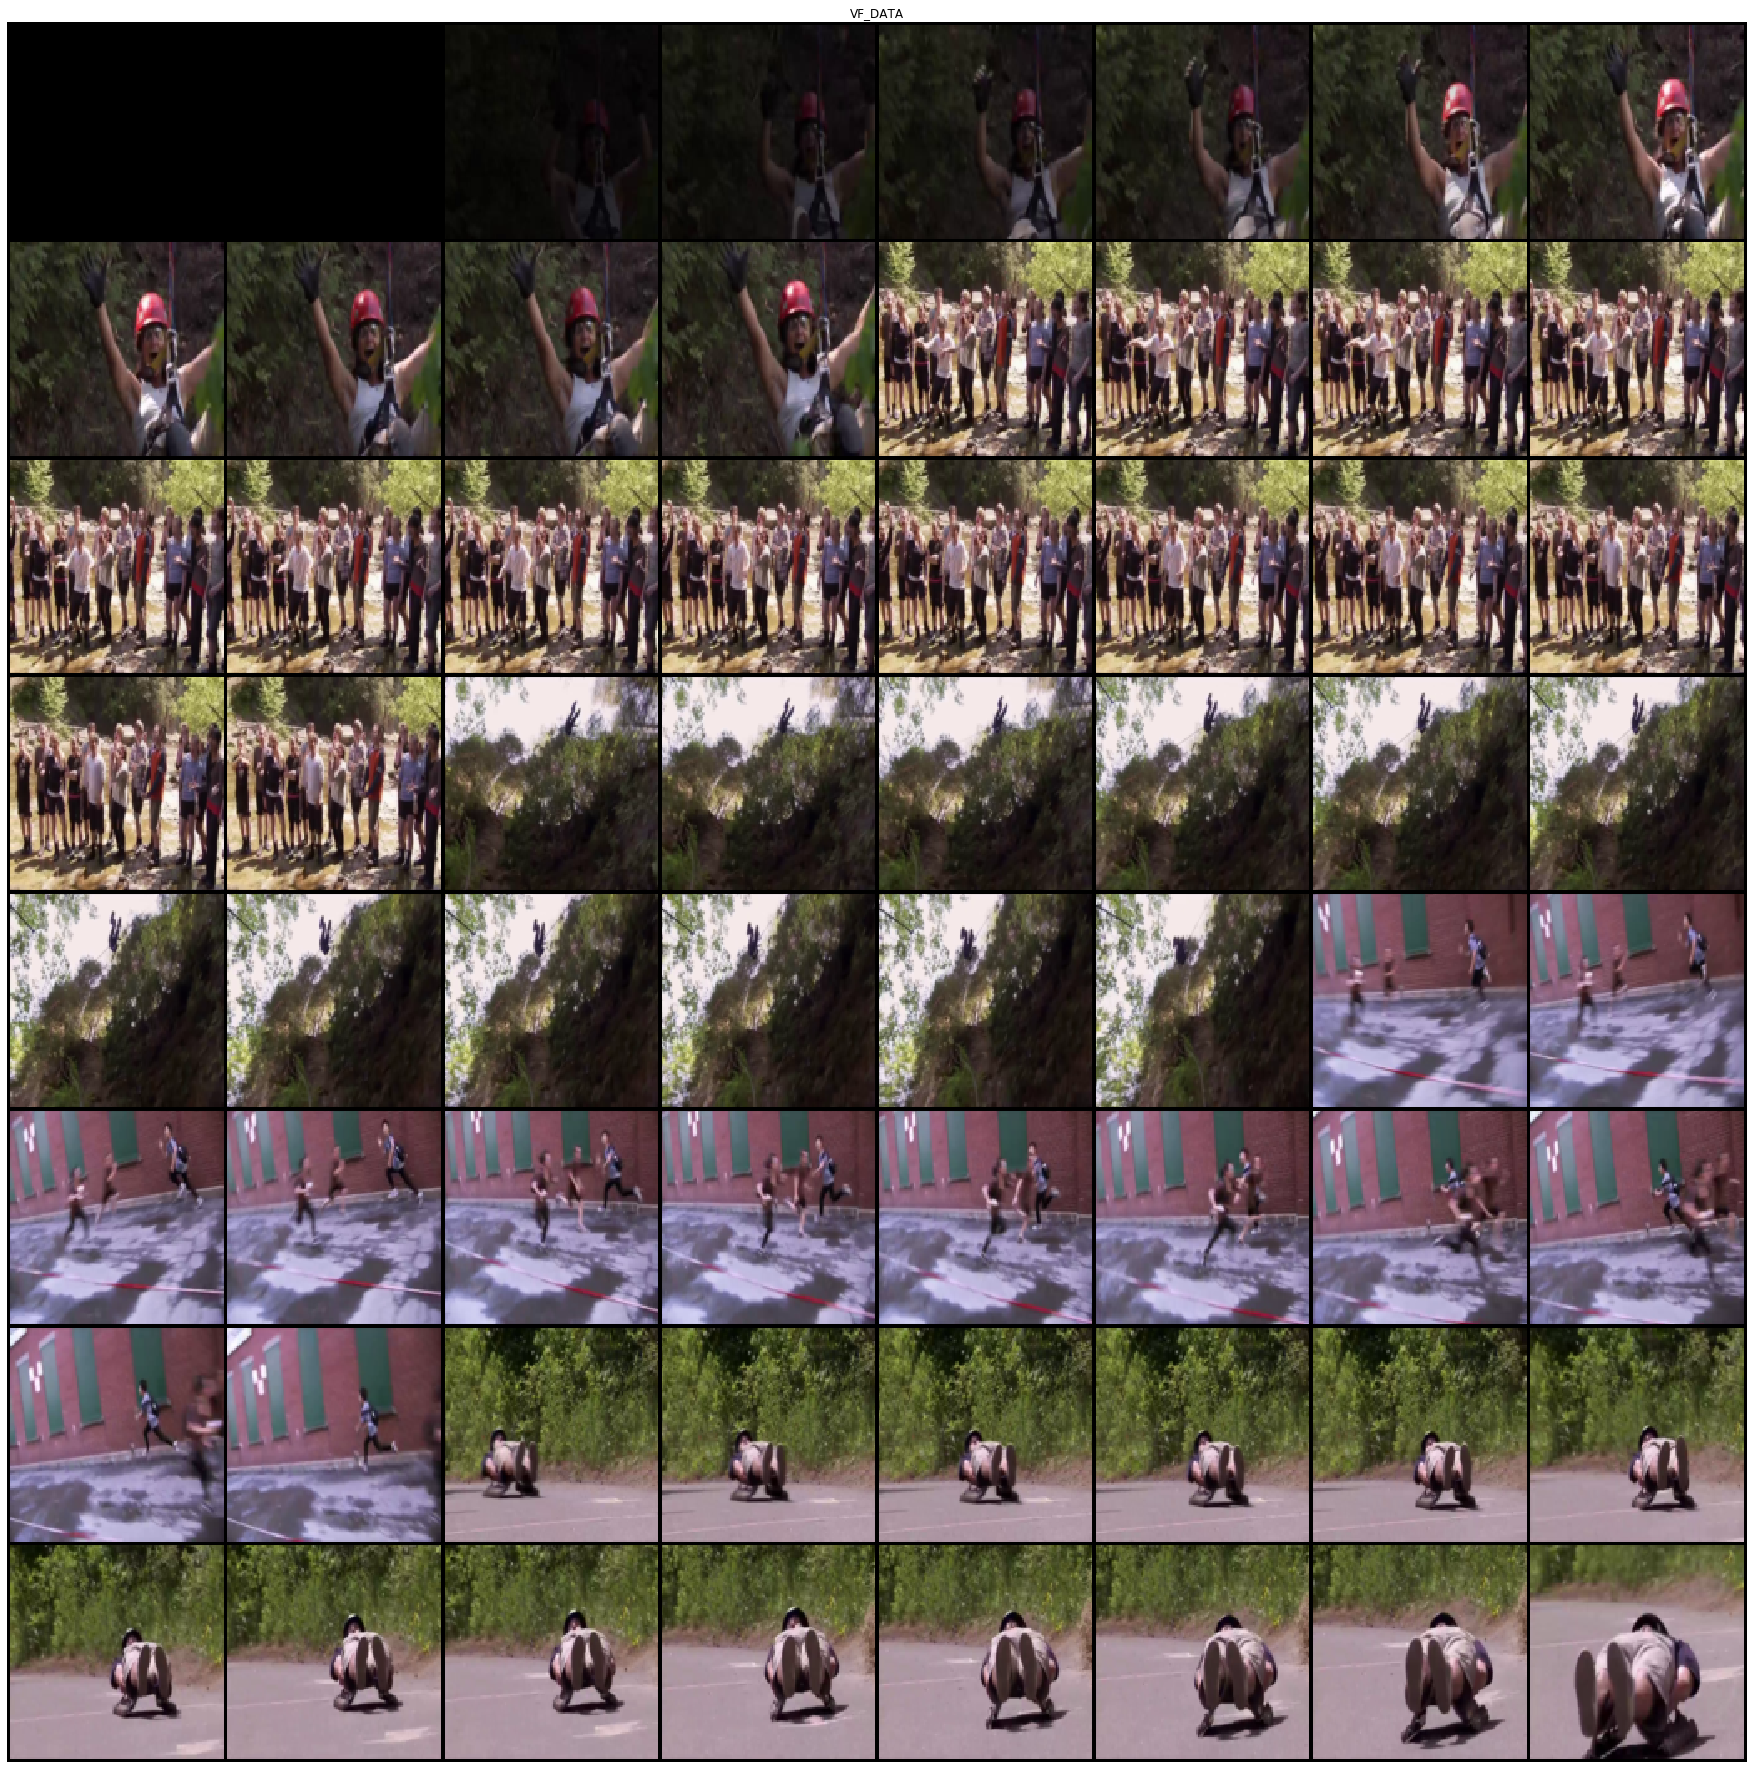

In [7]:
ds0_loader = torch.utils.data.DataLoader(ds0, batch_size=64)

show(ds0_loader)


## Audio Training Dataset

Training dataset for TTS, audio is aligned with text (uses captioning timestamps)

timestamp, text, audio buffer

In [6]:
#
# Custom Embedding function to embed text strings with word vectors
#
class MyFastTextEmbedding():
    def __init__(self, max_token_len=32, tokenizer="basic_english", language="en"):
        
        self.tokenizer = torchtext.data.get_tokenizer(tokenizer, language=language)
        self.vocab = torchtext.vocab.FastText(language=language)
        self.max_token_len = max_token_len

    def __call__(self, text):
        tokens = self.tokenizer(text)
        vec = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        pvec = torch.nn.functional.pad(vec, (0,0,self.max_token_len - vec.shape[0],0))
        return pvec

#
# Audio Transform to zero pad audio segment
#
class MyAudioTransform():
    def __init__(self, max_audio_len=0):
        self.max_audio_len = max_audio_len
        
    def __call__(self, audio):
        audio = torch.nn.functional.pad(audio, (self.max_audio_len - audio.shape[1],0))
        return audio
    
ds1 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    fields=[YouTubeDataset.F_TIME,  YouTubeDataset.F_CC_TEXT, YouTubeDataset.F_AF_DATA],
                    key=YouTubeDataset.F_CC_TEXT)
ds1.text_transform = MyFastTextEmbedding(max_token_len=64)
ds1.audio_transform = MyAudioTransform(max_audio_len=int(ds1.max_text_dur * ds1.audio_sr))

show(ds1)


['TIME', 'CC_TEXT', 'AF_DATA']
TIME 0.0
CC_TEXT torch.Size([64, 300])
AF_DATA torch.Size([1, 1110879])


### With Dataloader

In [ ]:
ds1_loader = torch.utils.data.DataLoader(ds1, batch_size=64)

show(ds1_loader)

## Video Captioning Dataset

Training Dataset for video captioning

timestamp, text, video_frames with video frames aligned to text and padded

In [7]:

ds2 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    fields=[YouTubeDataset.F_TIME,  YouTubeDataset.F_CC_TEXT, YouTubeDataset.F_VF_DATA],
                    key=YouTubeDataset.F_CC_TEXT)                  

show(ds2)

['TIME', 'CC_TEXT', 'VF_DATA']
TIME 0.06
CC_TEXT what's up guys me I'm getting here back
VF_DATA (3, 318, 640)


## Video, Audio, Text Dataset

timestamp, 5s video segment, audio, text aligned to video segment

In [5]:
ds3 = YouTubeDataset('data', 'SecretLocation', 'train', 
                    fields=[YouTubeDataset.F_TIME,  YouTubeDataset.F_VF_DATA, YouTubeDataset.F_AF_DATA, YouTubeDataset.F_CC_TEXT ],
                    key=YouTubeDataset.F_VF_DATA,
                    video_cliplen=5*24)                  

show(ds3)

Files already downloaded
['TIME', 'VF_DATA', 'AF_DATA', 'CC_TEXT']
TIME 0.0
VF_DATA torch.Size([120, 3, 318, 640])
AF_DATA torch.Size([2, 220500])
CC_TEXT what's up guys me I'm getting here back
